# PyMC, Aesara, and AePPL: The new kids on the block

Notebook available at [https://tinyurl.com/pymc-aesara-aeppl](https://tinyurl.com/pymc-aesara-aeppl)

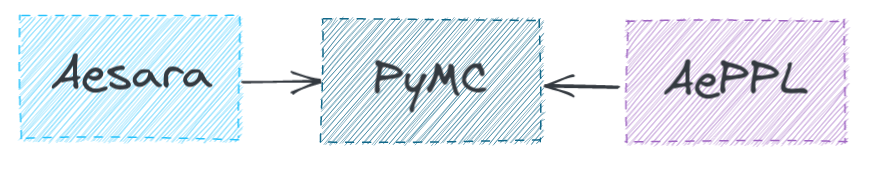

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import aeppl
import aesara
import aesara.tensor as at
import pymc as pm

In [31]:
pm.__version__, aesara.__version__, aeppl.__version__

('4.0.1', '2.7.3', '0.0.31')

# Aesara

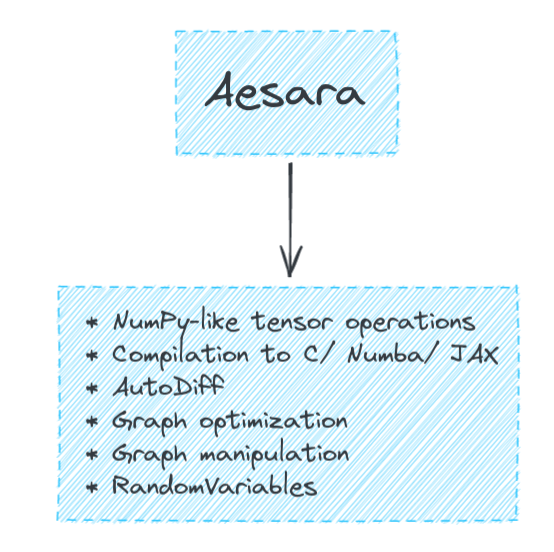

## Numpy-Like tensor operations

In [127]:
x = at.scalar(name='x')
y = at.vector(name='y')

# Broadcasts like Numpy
z = x + y
z.name = 'z = x + y'

# np.foo can usually be replaced by at.foo
w = at.log(z)
w.name = 'w = log(x + y)'

In [128]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'w = log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'z = x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [129]:
# Compile the graph into a I/O function that can be evaluated
f = aesara.function(inputs=[x, y], outputs=w)
f(x=0, y=[1, np.e])  # keyword arguments only valid (by default) for named variables

array([0., 1.])

In [130]:
# Sometimes we just want to debug, we can use `eval` for that
w.eval({x: 0, y:[1, np.e]})

array([0., 1.])

In [131]:
# You can build a function from intermediate variables as well
f = aesara.function(inputs=[z], outputs=w)
f([1, np.e])

array([0., 1.])

In [134]:
f([2*np.e])

array([1.69314718])

## Compilation to different backends

In [37]:
# f_numba = aesara.function(inputs=[z], outputs=w, mode="NUMBA")
# f_numba([1, np.e])

In [38]:
f_jax = aesara.function(inputs=[z], outputs=w, mode="JAX")
f_jax([1, np.e])

DeviceArray([0., 1.], dtype=float64)

## Automatic differentiation

In [39]:
x = at.scalar("x")
y = at.log(x)
y.name = "log(x)"

In [40]:
grad_y_wrt_x = at.grad(cost=y, wrt=x)
f = aesara.function(inputs=[x], outputs=[y, grad_y_wrt_x])
aesara.dprint(f)

Elemwise{log,no_inplace} [id A] 'log(x)' 0
 |x [id B]
Elemwise{reciprocal,no_inplace} [id C] '(dlog(x)/dx)' 1
 |x [id B]


In [41]:
f(2)

[array(0.69314718), array(0.5)]

## Automatic computational stabilization and specialization

In [42]:
x = at.matrix("x")
y = at.log(1 - at.exp(x))
aesara.dprint(y)

Elemwise{log,no_inplace} [id A]
 |Elemwise{sub,no_inplace} [id B]
   |InplaceDimShuffle{x,x} [id C]
   | |TensorConstant{1} [id D]
   |Elemwise{exp,no_inplace} [id E]
     |x [id F]


In [43]:
# Introduces specialized operator
f = aesara.function([x], y)
aesara.dprint(f)

Elemwise{log1mexp,no_inplace} [id A] 0
 |x [id B]


In [44]:
z = at.exp(x) + at.exp(x)
aesara.dprint(z)

Elemwise{add,no_inplace} [id A]
 |Elemwise{exp,no_inplace} [id B]
 | |x [id C]
 |Elemwise{exp,no_inplace} [id D]
   |x [id C]


In [45]:
# Reuses repeated computations
f = aesara.function([x], z)
aesara.dprint(f)

Elemwise{Composite{(exp(i0) + exp(i0))}} [id A] 0
 |x [id B]


## User friendly graph manipulation

In [46]:
x = at.scalar("x")
lam = at.scalar("lam")
pdf_x = 1 - at.exp(-lam * x)

In [47]:
pdf_x.eval({x: 1, lam: 2})

array(0.86466472)

In [48]:
# Variable substituion: let's use log(x) as input instead
pdf_log_x = aesara.clone_replace(output=pdf_x, replace={x: at.exp(x)})
pdf_log_x.eval({x: 0, lam: 2})

array(0.86466472)

## RandomVariables

In [49]:
loc = at.scalar("loc")
scale = at.constant(1.0, name="scale")  # could also just have used 1.0 as input
rng = aesara.shared(np.random.default_rng(seed=123), name="rng")  # This is another type of "mutable" constant
norm = at.random.normal(loc, scale, size=None, name='norm', rng=rng)
aesara.dprint(norm)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'norm'
 |rng [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |loc [id E]
 |scale{1.0} [id F]


In [50]:
# Constants cannot be passed an explicit inputs
f = aesara.function(inputs=[loc], outputs=norm)
f(0)

array(-0.98912135)

In [51]:
f(0)

array(-0.98912135)

In [52]:
# Update seed
rng.set_value(np.random.default_rng(seed=456))
f(0)

array(0.89603995)

In [53]:
f(0)

array(0.89603995)

In [54]:
# PyMC has a utility to create an Aesara function that updates seeds automatically
seeded_f = pm.aesaraf.compile_pymc(inputs=[loc], outputs=norm, random_seed=123)

In [55]:
seeded_f(0)

array(-0.58122349)

In [56]:
seeded_f(0)

array(-0.04749923)

In [57]:
seeded_f(1)

array(0.88854794)

In [58]:
seeded_f(1)

array(1.16651069)

# PyMC (random side)

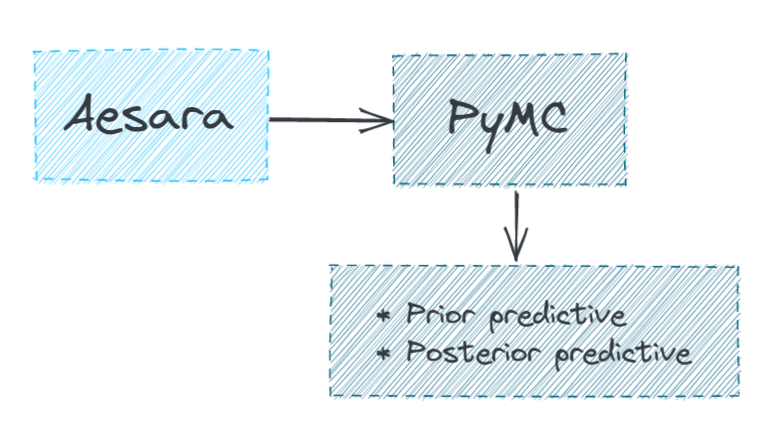

## Distributions are just RandomVariables

In [137]:
x = pm.Normal.dist(mu=0, tau=2, shape=3)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC35C1E0E40>) [id B]
 |TensorConstant{(1,) of 3} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{0.7071067811865476} [id F]


In [60]:
f = pm.aesaraf.compile_pymc(inputs=[], outputs=[x])
f(), f()

([array([ 0.27558433, -1.73719878, -0.38728968])],
 [array([ 0.29302179,  0.56952585, -0.28729647])])

In [61]:
with pm.Model() as model:
    x = pm.Normal("x", mu=np.array([0, 0]), tau=np.array([1, 2]), size=2)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'x'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC3AC5B1580>) [id B]
 |TensorConstant{(1,) of 2} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1.       ...70710678]} [id F]


In [62]:
pm.draw(x, draws=2)

array([[-0.81859128,  0.86070113],
       [-2.34423708, -0.92917898]])

## A PyMC model is just an Aesara graph composed of multiple RandomVariables

In [63]:
with pm.Model() as model:
    mu = pm.Normal("mu")
    log_sigma = pm.Normal("log_sigma")
    y = pm.Normal("y", mu=mu, sigma=at.exp(log_sigma), observed=[4, 5, 6])

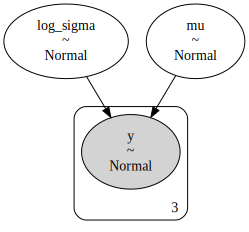

In [64]:
pm.model_to_graphviz(model)

In [65]:
model.free_RVs

[mu ~ N(0, 1), log_sigma ~ N(0, 1)]

In [66]:
model.observed_RVs

[y ~ N(mu, f(log_sigma))]

In [67]:
model.basic_RVs

[mu ~ N(0, 1), log_sigma ~ N(0, 1), y ~ N(mu, f(log_sigma))]

In [68]:
aesara.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC3AC13DE40>) [id B]
 |TensorConstant{(1,) of 3} [id C]
 |TensorConstant{11} [id D]
 |normal_rv{0, (0, 0), floatX, False}.1 [id E] 'mu'
 | |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC3AC13D580>) [id F]
 | |TensorConstant{[]} [id G]
 | |TensorConstant{11} [id H]
 | |TensorConstant{0} [id I]
 | |TensorConstant{1.0} [id J]
 |Elemwise{exp,no_inplace} [id K]
   |normal_rv{0, (0, 0), floatX, False}.1 [id L] 'log_sigma'
     |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC3AC13D900>) [id M]
     |TensorConstant{[]} [id N]
     |TensorConstant{11} [id O]
     |TensorConstant{0} [id P]
     |TensorConstant{1.0} [id Q]


## Prior predictive sampling

As simple as evaluating an Aesara function composed of RandomVariables

In [69]:
prior_pred_fn = pm.aesaraf.compile_pymc(
    inputs=[],
    outputs=model.basic_RVs
)

In [70]:
for i in range(2):
    print(prior_pred_fn())

[array(-0.69235213), array(0.42981373), array([-1.08615416, -1.08473594,  0.05225268])]
[array(0.82899285), array(0.00666309), array([2.70895677, 0.38712349, 1.24220618])]


In [71]:
with model:
    prior_pred = pm.sample_prior_predictive(samples=2, return_inferencedata=False)
prior_pred

{'log_sigma': array([0.818051  , 0.07971935]),
 'mu': array([0.81521577, 0.57193821]),
 'y': array([[-0.54605368, -1.0160598 , -3.42308985],
        [-0.97823707,  1.85474278, -0.90973338]])}

## Posterior predictive

Same as evaluating an Aesara function composed of RandomVariables, with some of the ancestor variables replaced by input values

In [72]:
post_pred_fn = pm.aesaraf.compile_pymc(
    inputs=model.free_RVs,
    outputs=model.observed_RVs
)

In [73]:
mu_draws = [5, 12]
log_sigma_draws = [-2, 1]

for mu_draw, log_sigma_draw in zip(mu_draws, log_sigma_draws):
    print(post_pred_fn(mu=mu_draw, log_sigma=log_sigma_draw))

[array([5.00299841, 4.95529298, 4.91167416])]
[array([18.24880254, 15.777672  , 15.15716223])]


# AePPL

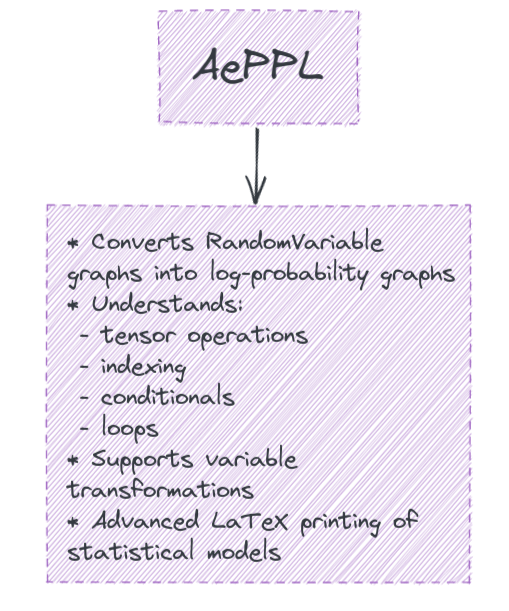

## Convert RandomVariable graphs into log-probability graphs

In [74]:
x_rv = at.random.normal(0, 1, name="x_rv")
x_vv = at.scalar(name="x_vv")

x_logp = aeppl.joint_logprob({x_rv: x_vv})
aesara.dprint(x_logp)

Sum{acc_dtype=float64} [id A]
 |Check{sigma > 0} [id B] 'x_vv_logprob'
   |Elemwise{sub,no_inplace} [id C]
   | |Elemwise{sub,no_inplace} [id D]
   | | |Elemwise{mul,no_inplace} [id E]
   | | | |TensorConstant{-0.5} [id F]
   | | | |Elemwise{pow,no_inplace} [id G]
   | | |   |Elemwise{true_div,no_inplace} [id H]
   | | |   | |Elemwise{sub,no_inplace} [id I]
   | | |   | | |x_vv [id J]
   | | |   | | |TensorConstant{0} [id K]
   | | |   | |TensorConstant{1} [id L]
   | | |   |TensorConstant{2} [id M]
   | | |Elemwise{log,no_inplace} [id N]
   | |   |Elemwise{sqrt,no_inplace} [id O]
   | |     |TensorConstant{6.283185307179586} [id P]
   | |Elemwise{log,no_inplace} [id Q]
   |   |TensorConstant{1} [id L]
   |All [id R]
     |Elemwise{gt,no_inplace} [id S]
       |TensorConstant{1} [id L]
       |TensorConstant{0.0} [id T]


In [75]:
x_logp.eval({x_vv: 0})

array(-0.91893853)

In [76]:
sp.stats.norm(0, 1).logpdf(0)

-0.9189385332046727

In [77]:
mu_rv = at.random.normal(0, 1, name="mu_rv")
log_sigma_rv = at.random.normal(0, 1, name="log_sigma_rv")
y_rv = at.random.normal(mu_rv, at.exp(log_sigma_rv), size=(3,))

mu_vv = at.scalar(name="mu_vv")
log_sigma_vv = at.scalar(name="log_sigma_vv")
y_vv = at.constant([3.0, 4.0, 5.0])

joint_logp = aeppl.joint_logprob({
    mu_rv: mu_vv,
    log_sigma_rv: log_sigma_vv,
    y_rv: y_vv
})
# aesara.dprint(joint_logp)

In [78]:
f = aesara.function([mu_vv, log_sigma_vv], joint_logp)
f(mu_vv=3, log_sigma_vv=-1)

array(-25.06733291)

In [79]:
(
    sp.stats.norm(0, 1).logpdf(3)
    + sp.stats.norm(0, 1).logpdf(-1)
    + sp.stats.norm(3, np.exp(-1)).logpdf([3.0, 4.0, 5.0]).sum()
)

-25.067332913349986

## Create log-probability graphs conditioned on (arbitrary) operations

In [80]:
# Condition on the exponent of a RandomVariable
log_x_rv = at.random.normal(0, 1)
x_rv = at.exp(log_x_rv)

x_vv = at.scalar("x")

x_logp = aeppl.joint_logprob({x_rv: x_vv})

In [81]:
x_logp.eval({x_vv: 2})

array(-1.85231222)

In [82]:
sp.stats.lognorm(s=1).logpdf(2)

-1.8523122207237186

In [83]:
# Condition on a cumulative sum
innov_rv = at.random.normal(0, 1, size=10)
cum_rv = at.cumsum(innov_rv)

cum_vv = at.vector()
cum_logp = aeppl.joint_logprob({cum_rv: cum_vv}, sum=False)

In [84]:
cum_logp.eval({cum_vv: np.arange(10)})

array([-0.91893853, -1.41893853, -1.41893853, -1.41893853, -1.41893853,
       -1.41893853, -1.41893853, -1.41893853, -1.41893853, -1.41893853])

In [85]:
# Condition on a concatenated tensor
first_rv = at.random.normal(0, 1, size=3)
second_rv = at.random.normal(0, 2, size=4)
stack_rv = at.concatenate((first_rv, second_rv))

stack_vv = at.vector()

stack_logp = aeppl.joint_logprob({stack_rv: stack_vv}, sum=False)

In [86]:
stack_logp.eval({stack_vv: np.zeros(7)})

array([-0.91893853, -0.91893853, -0.91893853, -1.61208572, -1.61208572,
       -1.61208572, -1.61208572])

In [87]:
# Combine different operations
init_rv = at.exp(at.random.normal(0, 1))
innov_rv = at.cumsum(at.random.normal(0, 1, size=9))
grw_rv = at.concatenate((init_rv[None], innov_rv))

grw_vv = at.vector()

grw_logp = aeppl.joint_logprob({grw_rv: grw_vv}, sum=False)

In [88]:
grw_logp.eval({grw_vv: np.arange(1, 11)})

array([-0.91893853, -2.91893853, -1.41893853, -1.41893853, -1.41893853,
       -1.41893853, -1.41893853, -1.41893853, -1.41893853, -1.41893853])

In [89]:
# Combine multiple variables
drift_rv = -1 * at.random.exponential()
grw_rv = at.cumsum(at.random.normal(drift_rv, 1, size=10))

drift_vv = at.scalar("drift")
grw_vv = at.vector("grw")

# We can obtain the logp term for each variable separately
fact_logp = aeppl.factorized_joint_logprob({
    drift_rv: drift_vv,
    grw_rv: grw_vv,
})

In [90]:
fact_logp

{drift: drift_logprob, grw: grw_logprob}

In [91]:
fact_logp_fn = aesara.function([drift_vv, grw_vv], list(fact_logp.values()))

In [92]:
fact_logp_fn(drift=0, grw=np.arange(1, 11))

[array(0.),
 array([-1.41893853, -1.41893853, -1.41893853, -1.41893853, -1.41893853,
        -1.41893853, -1.41893853, -1.41893853, -1.41893853, -1.41893853])]

In [93]:
fact_logp_fn(drift=-1, grw=np.arange(1, 11))

[array(-1.),
 array([-2.91893853, -2.91893853, -2.91893853, -2.91893853, -2.91893853,
        -2.91893853, -2.91893853, -2.91893853, -2.91893853, -2.91893853])]

In [94]:
fact_logp_fn(drift=-1, grw=-1 * np.arange(1, 11))

[array(-1.),
 array([-0.91893853, -0.91893853, -0.91893853, -0.91893853, -0.91893853,
        -0.91893853, -0.91893853, -0.91893853, -0.91893853, -0.91893853])]

In [95]:
# ADD EXAMPLE WITH MIXTURE

# PyMC (probability side)

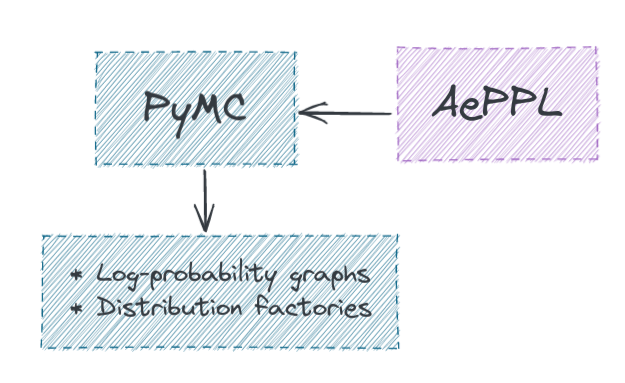

## PyMC uses Aeppl to transform RandomVariable graphs into log-probability graphs

In [96]:
with pm.Model() as model:
    mu = pm.Normal("mu")
    log_sigma = pm.Normal("log_sigma")
    y = pm.Normal("y", mu, at.exp(log_sigma), observed=[3, 4, 5])

In [97]:
aesara.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC394283C80>) [id B]
 |TensorConstant{(1,) of 3} [id C]
 |TensorConstant{11} [id D]
 |normal_rv{0, (0, 0), floatX, False}.1 [id E] 'mu'
 | |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC394283040>) [id F]
 | |TensorConstant{[]} [id G]
 | |TensorConstant{11} [id H]
 | |TensorConstant{0} [id I]
 | |TensorConstant{1.0} [id J]
 |Elemwise{exp,no_inplace} [id K]
   |normal_rv{0, (0, 0), floatX, False}.1 [id L] 'log_sigma'
     |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC394283D60>) [id M]
     |TensorConstant{[]} [id N]
     |TensorConstant{11} [id O]
     |TensorConstant{0} [id P]
     |TensorConstant{1.0} [id Q]


In [98]:
model.rvs_to_values

{mu ~ N(0, 1): mu,
 log_sigma ~ N(0, 1): log_sigma,
 y ~ N(mu, f(log_sigma)): y{[3. 4. 5.]}}

In [99]:
model_logp = model.logp()
# aesara.dprint(model_logp)

In [100]:
model.value_vars

[mu, log_sigma]

In [101]:
logp_fn = aesara.function(model.value_vars, model_logp)

In [102]:
logp_fn(mu=3, log_sigma=-1)

array(-25.06733291)

In [103]:
# We can also take gradients!
model_dlogp = model.dlogp()
dlogp_fn = aesara.function(model.value_vars, model_dlogp)
dlogp_fn(mu=3, log_sigma=-1)

array([19.1671683 , 34.94528049])

## Sampling (or optimizing)

Once we have log-probabilities and gradients we can use them for bayesian inference

In [104]:
with model:
    map_ = pm.find_MAP()
map_

{'mu': array(1.33641649), 'log_sigma': array(0.89414627)}

In [105]:
sp.optimize.minimize(
    fun=lambda x: -logp_fn(*x),
    jac = lambda x: -dlogp_fn(*x),
    x0=[0.5, 0.5],
)

      fun: 10.516959396743076
 hess_inv: array([[ 1.41372771, -0.41646555],
       [-0.41646555,  0.23155113]])
      jac: array([-9.48891790e-08, -1.13824334e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([1.33641627, 0.89414655])

## PyMC uses Aeppl to build new distribution types

In [106]:
mu_true = -1.5

rng = np.random.default_rng(123)
y_raw = rng.normal(mu_true, size=10)
y_obs = np.clip(y_raw, -1, 1)
y_obs

array([-1.        , -1.        , -0.21207474, -1.        , -0.5797691 ,
       -0.92289621, -1.        , -0.95804778, -1.        , -1.        ])

In [107]:
with pm.Model() as model:
    mu = pm.Normal("mu")
    # Under the hood, this is roughly equivalent to
    # y = at.clip(at.random.normal(mu, size=10), -1, 1)
    y = pm.Censored("y", pm.Normal.dist(mu), lower=-1, upper=1, observed=y_obs)

In [108]:
aesara.dprint(y)

Elemwise{clip,no_inplace} [id A] 'y'
 |normal_rv{0, (0, 0), floatX, False}.1 [id B]
 | |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC35C388900>) [id C]
 | |SpecifyShape [id D]
 | | |MakeVector{dtype='int64'} [id E]
 | | | |Subtensor{int64} [id F]
 | | |   |Shape [id G]
 | | |   | |normal_rv{0, (0, 0), floatX, False}.1 [id H]
 | | |   |   |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC35C388900>) [id C]
 | | |   |   |TensorConstant{(1,) of 10} [id I]
 | | |   |   |TensorConstant{11} [id J]
 | | |   |   |normal_rv{0, (0, 0), floatX, False}.1 [id K] 'mu'
 | | |   |   | |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC35C6C6580>) [id L]
 | | |   |   | |TensorConstant{[]} [id M]
 | | |   |   | |TensorConstant{11} [id N]
 | | |   |   | |TensorConstant{0} [id O]
 | | |   |   | |TensorConstant{1.0} [id P]
 | | |   |   |TensorConstant{1.0} [id Q]
 | | |   |ScalarConstant{0} [id R]
 | | |TensorConstant{1} [id S]
 | |TensorConstant{11} [id T]
 | |normal_rv{0, (0, 0), 

In [109]:
with model:
    prior_pred = pm.sample_prior_predictive()

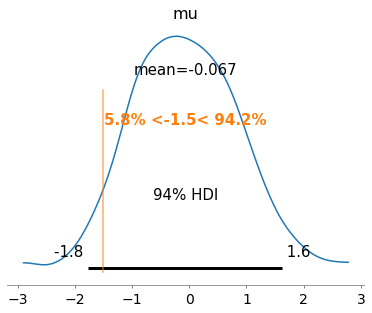

In [110]:
az.plot_posterior(prior_pred.prior["mu"], ref_val=mu_true);

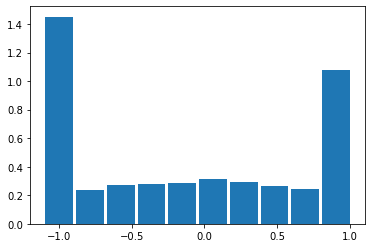

In [111]:
ax = az.plot_dist(prior_pred.prior_predictive["y"], kind="hist")
ax.set_xticks([-1, -0.5, 0, 0.5, 1]);

In [112]:
with model:
    post = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
INFO:pymc:NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


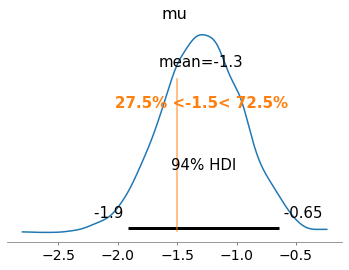

In [113]:
az.plot_posterior(post, ref_val=mu_true);

In [114]:
with model:
    post_pred = pm.sample_posterior_predictive(post)

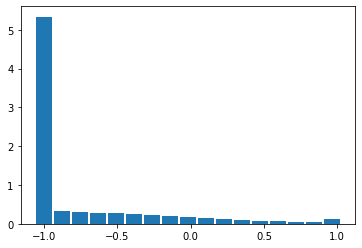

In [115]:
ax = az.plot_dist(post_pred.posterior_predictive["y"], kind="hist")
ax.set_xticks([-1, -0.5, 0, 0.5, 1]);

## Users will be able to define arbitrary distributions (WIP)

In [116]:
# Taking advantage of Aeppl to write a mixture model in PyMC
with pm.Model(coords={'trials': np.arange(10)}) as m:
    
    idx = pm.Categorical('idx', p=[0.1, 0.3, 0.6], dims='trials')

    components = at.stack([
        pm.Laplace.dist(mu=-5, b=1),
        pm.Normal.dist(mu=0, sigma=1),
        pm.StudentT.dist(nu=7, mu=5, sigma=1),
    ])

    # Aeppl understands indexing of RandomVariables that correspond 
    # to Mixture graphs
    mix = components[idx]

    # Manual registration
    m.register_rv(mix, name='mix', dims='trials', initval="prior")

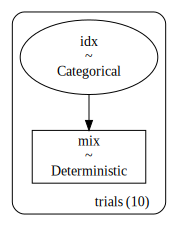

In [117]:
pm.model_to_graphviz(m)

In [118]:
m.initial_point(0)

{'idx': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'mix': array([6.99933659, 6.99933659, 6.99933659, 6.99933659, 6.99933659,
        6.99933659, 6.99933659, 6.99933659, 6.99933659, 6.99933659])}

In [119]:
with m:
    prior = pm.sample_prior_predictive(return_inferencedata=False)

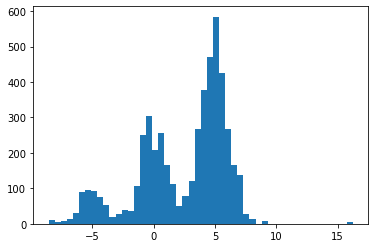

In [120]:
plt.hist(prior['mix'].reshape(-1), bins=50);

In [121]:
# Let's condition on the first draw
prior["mix"][0]

array([ 4.4390132 ,  4.4390132 ,  4.4390132 , -4.35946693,  4.4390132 ,
        4.4390132 ,  4.4390132 ,  4.4390132 , -4.35946693,  4.4390132 ])

In [122]:
prior["idx"][0]

array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2])

In [123]:
# Same model but with observed
# We can't use dims... it breaks something in Aeppl, perhaps the SpecifyShape?
with pm.Model(coords={'trials': np.arange(10)}) as m:

    idx = pm.Categorical('idx', p=[0.1, 0.3, 0.6], size=10)

    components = at.stack([
        pm.Laplace.dist(mu=-5, b=1),
        pm.Normal.dist(mu=0, sigma=1),
        pm.StudentT.dist(nu=7, mu=5, sigma=1),
    ])

    mix = components[idx]

    # Now we pass data when we register the variable!
    m.register_rv(mix, name='mix', data=prior['mix'][0])

In [124]:
with m:
    trace = pm.sample(return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
CategoricalGibbsMetropolis: [idx]
INFO:pymc:CategoricalGibbsMetropolis: [idx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [125]:
# Posterior indexes
np.median(trace['idx'], axis=0).astype(int)

array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2])

In [126]:
# True indexes
prior['idx'][0]

array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2])